Dataset cargado: (89400, 16, 16, 3)
Train: (80460, 16, 16, 3) Val: (8940, 16, 16, 3)
Epoch 1/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0877 - val_loss: 0.0290
Epoch 2/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0255 - val_loss: 0.0194
Epoch 3/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0179 - val_loss: 0.0156
Epoch 4/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0148 - val_loss: 0.0133
Epoch 5/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0129 - val_loss: 0.0121
Epoch 6/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 7/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 8/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0100 - val_loss: 0.0098
Epoch 9/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 10/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 11/25
629/629 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step -

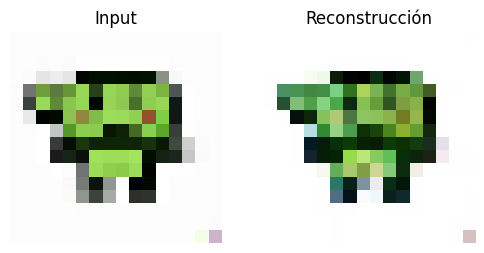

In [ ]:
# ============================================================
# EXPERIMENTO 1 — AUTOENCODER & DENOISING AUTOENCODER
# Basado en archivo NPZ ya generado en tu pipeline TDSP
# ============================================================

import os
import numpy as np
import mlflow
import mlflow.keras
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# ============================================================
# 1. CONFIGURAR MLflow
# ============================================================

MLFLOW_URL = "https://fleecier-rufus-decadently.ngrok-free.dev"   # <-- PON AQUÍ TU URL

mlflow.set_tracking_uri(MLFLOW_URL)
mlflow.set_experiment("Exp1-Autoencoder")


# ============================================================
# 2. CARGAR EL NPZ
# ============================================================

npz_path = "./data/intermediate/pixel_art_data.npz"  # <-- AJÚSTALO según donde lo montes

data = np.load(npz_path)
images = data["images"]       # (N, 16,16,3)
labels = data["labels"]       # (N,)
labels_one_hot = data["labels_one_hot"]

print("Dataset cargado:", images.shape)


# ============================================================
# 3. SPLIT TRAIN/VAL
# ============================================================

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(images, test_size=0.1, random_state=42)
print("Train:", X_train.shape, "Val:", X_val.shape)


# ============================================================
# 4. FUNCIONES AUXILIARES
# ============================================================

def add_gaussian_noise(x, sigma=0.15):
    noise = np.random.normal(0, sigma, x.shape).astype(np.float32)
    noisy = x + noise
    noisy = np.clip(noisy, 0.0, 1.0)
    return noisy


# ============================================================
# 5. DEFINIR AUTOENCODER
# ============================================================

def build_autoencoder(latent_dim=64):
    inputs = layers.Input(shape=(16,16,3))

    # ---- Encoder ----
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)  # 16 → 8

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)  # 8 → 4

    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation="linear")(x)

    # ---- Decoder ----
    x = layers.Dense(4*4*64)(latent)
    x = layers.Reshape((4,4,64))(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)  # 4→8
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)  # 8→16

    outputs = layers.Conv2D(3, 3, padding="same", activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-3), loss="mse")
    return model


# ============================================================
# 6. ENTRENAMIENTO DE AE & DAE
# ============================================================

latent_dim = 64
noise_sigma = 0.15
epochs = 25
batch_size = 128

autoencoder = build_autoencoder(latent_dim)

# Crear datos ruidosos para DAE
X_train_noisy = add_gaussian_noise(X_train, sigma=noise_sigma)
X_val_noisy   = add_gaussian_noise(X_val, sigma=noise_sigma)


# ============================================================
# 7. ENTRENAR & LOGGEAR EN MLFLOW
# ============================================================

with mlflow.start_run(run_name="AE-vs-DAE"):

    mlflow.log_param("latent_dim", latent_dim)
    mlflow.log_param("noise_sigma", noise_sigma)
    mlflow.log_param("epochs", epochs)

    es = EarlyStopping(patience=5, restore_best_weights=True)

    history = autoencoder.fit(
        X_train_noisy, X_train,
        validation_data=(X_val_noisy, X_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=1
    )

    # -------------------
    # MÉTRICAS FINALES
    # -------------------
    val_pred = autoencoder.predict(X_val[:1000])
    val_true = X_val[:1000]

    mse_value = np.mean((val_pred - val_true)**2)
    psnr_value = np.mean([psnr(val_true[i], val_pred[i]) for i in range(50)])
    ssim_value = np.mean([
    ssim(
        val_true[i],
        val_pred[i],
        channel_axis=2,
        data_range=1.0   # <--- ESTA ES LA SOLUCIÓN
    )
    for i in range(50)
])


    mlflow.log_metric("val_loss", history.history["val_loss"][-1])
    mlflow.log_metric("MSE", mse_value)
    mlflow.log_metric("PSNR", psnr_value)
    mlflow.log_metric("SSIM", ssim_value)

    # -------------------
    # GUARDAR MODELO Y RECONSTRUCCIÓN
    # -------------------
    os.makedirs("artifacts_exp1", exist_ok=True)

    model_path = "artifacts_exp1/autoencoder_model.keras"
    autoencoder.save(model_path)
    mlflow.log_artifact(model_path)

    # Reconstrucción visual
    fig = plt.figure(figsize=(6,6))
    idx = np.random.randint(0, 1000)
    plt.subplot(1,2,1)
    plt.title("Input")
    plt.imshow(val_true[idx])
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Reconstrucción")
    plt.imshow(val_pred[idx])
    plt.axis("off")

    recon_path = "artifacts_exp1/reconstruction.png"
    plt.savefig(recon_path)
    mlflow.log_artifact(recon_path)

    # Guardar latentes
    encoder = models.Model(autoencoder.input, autoencoder.layers[-7].output)
    latents = encoder.predict(X_val[:2000])

    np.save("artifacts_exp1/latents.npy", latents)
    mlflow.log_artifact("artifacts_exp1/latents.npy")

print("=== EXP1 COMPLETADO ===")